In [ ]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Set plot styles
sns.set(style="whitegrid")

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set up the logger
logging.basicConfig(filename='data_cleaning_and_analysis.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger()
logger.info("Logger initialized and ready to log the steps.")

In [ ]:
# Transformer for handling missing values
class HandleMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        logger.info("Handling missing values...")

        X['CompetitionDistance'].fillna(X['CompetitionDistance'].median(), inplace=True)
        logger.info("Filled 'CompetitionDistance' missing values with median.")

        X['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
        X['CompetitionOpenSinceYear'].fillna(0, inplace=True)
        logger.info("Filled 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' with 0.")

        X['Promo2SinceWeek'].fillna(0, inplace=True)
        X['Promo2SinceYear'].fillna(0, inplace=True)
        X['PromoInterval'].fillna('None', inplace=True)
        logger.info("Filled promo-related missing values with default values.")

        X['Open'].fillna(0, inplace=True)
        logger.info("Filled 'Open' missing values with 0.")

        return X

# Transformer for handling outliers
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.medians = {}
        self.bounds = {}
        for column in self.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds[column] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.medians[column] = X[column].median()
        return self

    def transform(self, X):
        logger.info("Handling outliers...")
        for column in self.columns:
            lower_bound, upper_bound = self.bounds[column]
            median = self.medians[column]
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median, X[column])
            logger.info(f"Replaced outliers in '{column}' with median.")
        return X


    # Transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        logger.info("Performing feature engineering...")

        X['CompetitionOpenSinceDate'] = pd.to_datetime(
            dict(year=X['CompetitionOpenSinceYear'],
                 month=X['CompetitionOpenSinceMonth'],
                 day=1),
            errors='coerce'
        )
        X['CompetitionOpenSinceDate'].fillna(0, inplace=True) # handle if any missing value generate here
        logger.info("Created 'CompetitionOpenSinceDate'.")

        X['Date'] = pd.to_datetime(X['Date'])
        X['Year'] = X['Date'].dt.year
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day
        X['WeekOfYear'] = X['Date'].dt.isocalendar().week
        X['DayOfWeek'] = X['Date'].dt.dayofweek

        logger.info("Extracted date-related features: Year, Month, Day, WeekOfYear, DayOfWeek.")
        return X

In [ ]:
# Load The dataset
from google.colab import files


uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving store.csv to store.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# Load datasets
logger.info("Loading datasets...")

try:
    train = pd.read_csv('train.csv')
    store = pd.read_csv('store.csv')
    test = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    logger.info("Datasets loaded successfully.")
except Exception as e:
    logger.error(f"Error loading datasets: {e}")

# Log dataset shapes
logger.info(f"train dataset shape: {train.shape}")
logger.info(f"store dataset shape: {store.shape}")
logger.info(f"test dataset shape: {test.shape}")
logger.info(f"sample_submission dataset shape: {sample_submission.shape}")

# Merge datasets
try:
    train_store = pd.merge(train, store, how='left', on='Store') #merge train and store dataset
    test_store = pd.merge(test, store, how='left', on='Store') #merge test and store dataset
    test_store = pd.merge(test_store,sample_submission,how='left',on='Id') #merge test_store and sample_submission
    logger.info("Datasets merged successfully.")
except Exception as e:
    logger.error(f"Error merging datasets: {e}")

# Log merged dataset shapes
logger.info(f"train_store dataset shape: {train_store.shape}")
logger.info(f"test_store dataset shape: {test_store.shape}")

In [ ]:
# check few rows of dataset
sample_submission.sample(5)

,Id,Sales
8968,8969,0
2648,2649,0
35955,35956,0
21948,21949,0
29442,29443,0


In [ ]:
# check few rows of dataset
store.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
373,374,a,a,1150.0,9.0,2007.0,0,NaN,NaN,NaN
397,398,c,c,1540.0,NaN,NaN,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
1048,1049,a,a,370.0,7.0,2012.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
795,796,a,c,7180.0,11.0,2012.0,0,NaN,NaN,NaN
527,528,a,c,20620.0,NaN,NaN,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


In [ ]:
# check few rows of dataset
train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
93530,986,6,2015-05-09,4249,583,1,0,0,0
539852,978,3,2014-03-05,8556,1117,1,1,0,0
664501,747,3,2013-11-13,6333,570,1,0,0,0
142846,127,3,2015-03-25,3735,531,1,0,0,0
562010,836,4,2014-02-13,5055,699,1,0,0,0


In [ ]:
train['StateHoliday'].value_counts()

,count
StateHoliday,
0,855087
0,131072
a,20260
b,6690
c,4100


In [ ]:
# check few rows of dataset
test.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
36734,36735,1019,4,2015-08-06,1.0,1,0,1
11994,11995,15,4,2015-09-03,1.0,1,0,0
9728,9729,408,7,2015-09-06,0.0,0,0,0
25161,25162,435,3,2015-08-19,1.0,1,0,0
21593,21594,251,7,2015-08-23,0.0,0,0,0


In [ ]:
# check nan values
train_store.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


In [ ]:
# check nan values
test_store.isnull().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,11
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0
Assortment,0


In [ ]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('missing_values', HandleMissingValues()),
    ('outliers', HandleOutliers(columns=['Sales','CompetitionDistance'])),
    ('feature_engineering', FeatureEngineering())
    ])

# Apply the preprocessing pipeline
try:
    train_store = preprocessing_pipeline.fit_transform(train_store)
    test_store = preprocessing_pipeline.transform(test_store)
    logger.info("Preprocessing pipeline applied successfully.")
except Exception as e:
    logger.error(f"Error applying preprocessing pipeline: {e}")

# Log processed dataset shapes
logger.info(f"Processed train_store dataset shape: {train_store.shape}")
logger.info(f"Processed test_store dataset shape: {test_store.shape}")

In [ ]:
# Checke if missing values handled or not
train_store.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


In [ ]:
# Checke if missing values handled or not
test_store.isnull().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0
Assortment,0


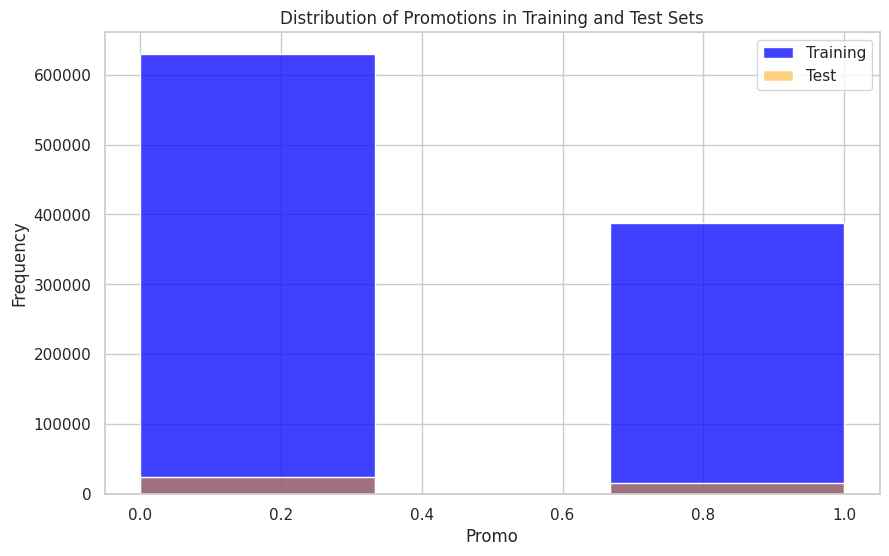

In [ ]:
# Function to check promo distribution in training and test sets
def analyze_promo_distribution(train, test):
    logger.info("Analyzing distribution of promotions in training and test sets...")
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(train['Promo'], label='Training', kde=False, bins=3, color='blue')
        sns.histplot(test['Promo'], label='Test', kde=False, bins=3, color='orange', alpha=0.5)
        plt.title('Distribution of Promotions in Training and Test Sets')
        plt.xlabel('Promo')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        logger.info("Plotted distribution of promotions in training and test sets.")
    except Exception as e:
        logger.error(f"Error plotting distribution of promotions: {e}")

# Apply analysis function
try:
    analyze_promo_distribution(train_store, test_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

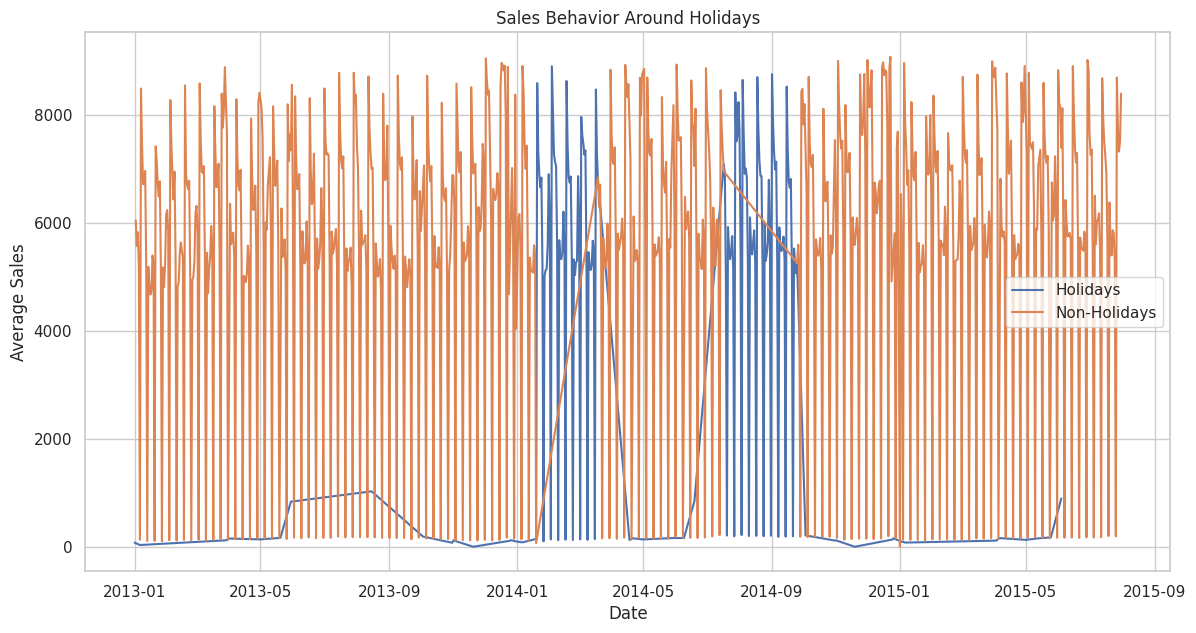

In [ ]:
# Function to analyze sales behavior around holidays
def analyze_holiday_sales_behavior(data):
    logger.info("Analyzing sales behavior around holidays...")
    try:
        holidays = data[data['StateHoliday'] != '0']
        non_holidays = data[data['StateHoliday'] == '0']

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=holidays.groupby('Date')['Sales'].mean(), label='Holidays')
        sns.lineplot(data=non_holidays.groupby('Date')['Sales'].mean(), label='Non-Holidays')
        plt.title('Sales Behavior Around Holidays')
        plt.xlabel('Date')
        plt.ylabel('Average Sales')
        plt.legend()
        plt.show()
        logger.info("Plotted sales behavior around holidays.")
    except Exception as e:
        logger.error(f"Error plotting sales behavior around holidays: {e}")

# Apply analysis function
try:
    analyze_holiday_sales_behavior(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

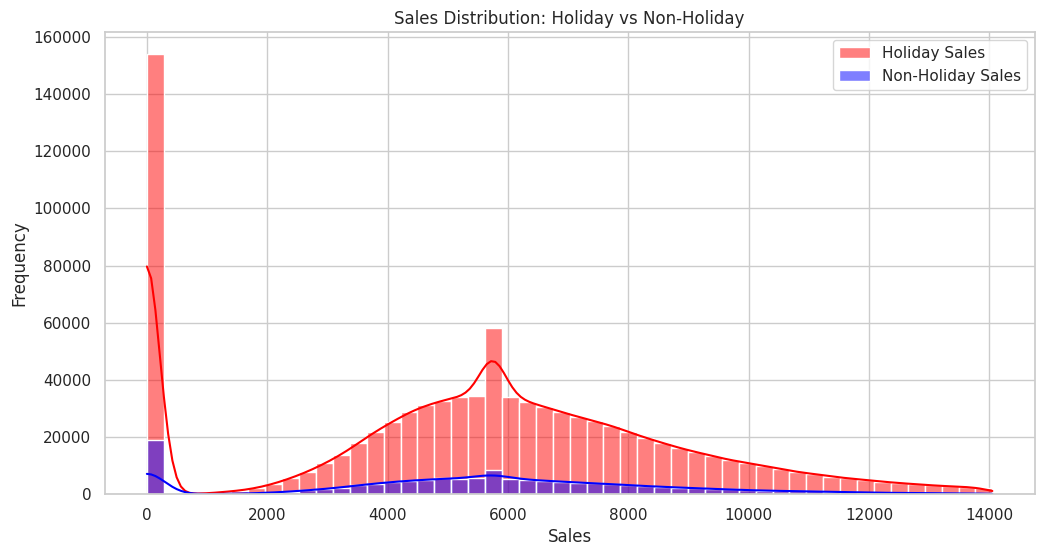

In [ ]:
# Compare sales behavior before, during, and after holidays
#train_store['StateHoliday'] = train_store['StateHoliday'].replace({'0': 'None'})
holiday_sales = train_store[train_store['StateHoliday'] != 0]
non_holiday_sales = train_store[train_store['StateHoliday'] == 0]

plt.figure(figsize=(12, 6))
sns.histplot(holiday_sales['Sales'], bins=50, kde=True, label='Holiday Sales', color='red')
sns.histplot(non_holiday_sales['Sales'], bins=50, kde=True, label='Non-Holiday Sales', color='blue')
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.legend()
plt.show()

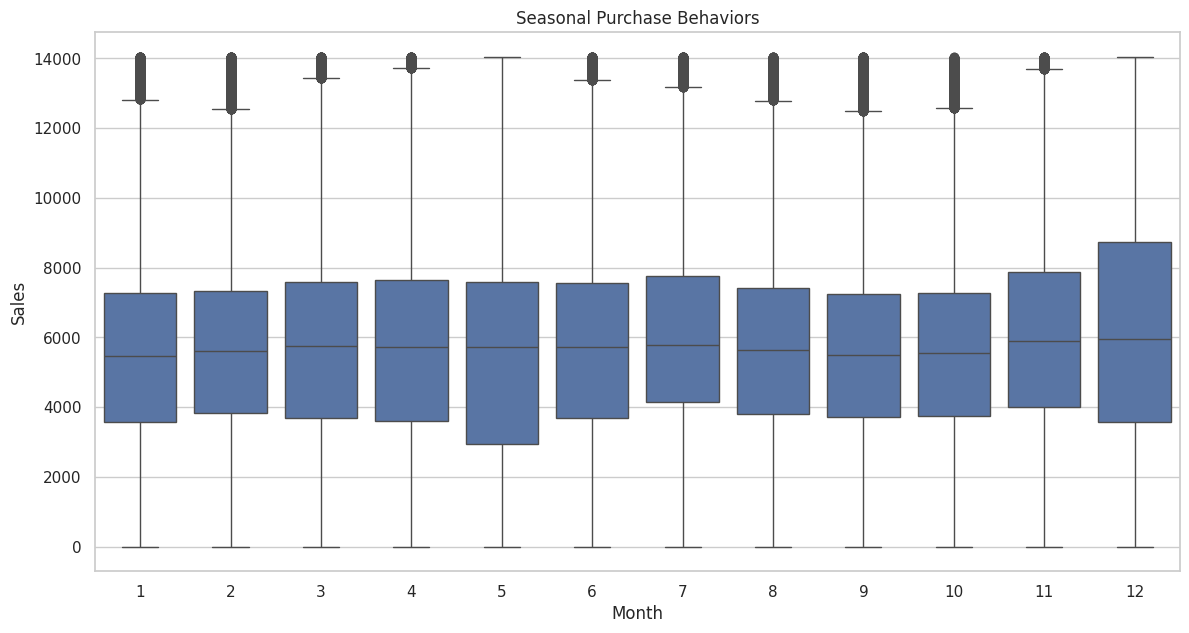

In [ ]:
# Function to analyze seasonal purchase behaviors
def analyze_seasonal_behaviors(data):
    logger.info("Analyzing seasonal purchase behaviors...")
    try:
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='Month', y='Sales', data=data)
        plt.title('Seasonal Purchase Behaviors')
        plt.xlabel('Month')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted seasonal purchase behaviors.")
    except Exception as e:
        logger.error(f"Error plotting seasonal purchase behaviors: {e}")

# Apply analysis function
try:
    analyze_seasonal_behaviors(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

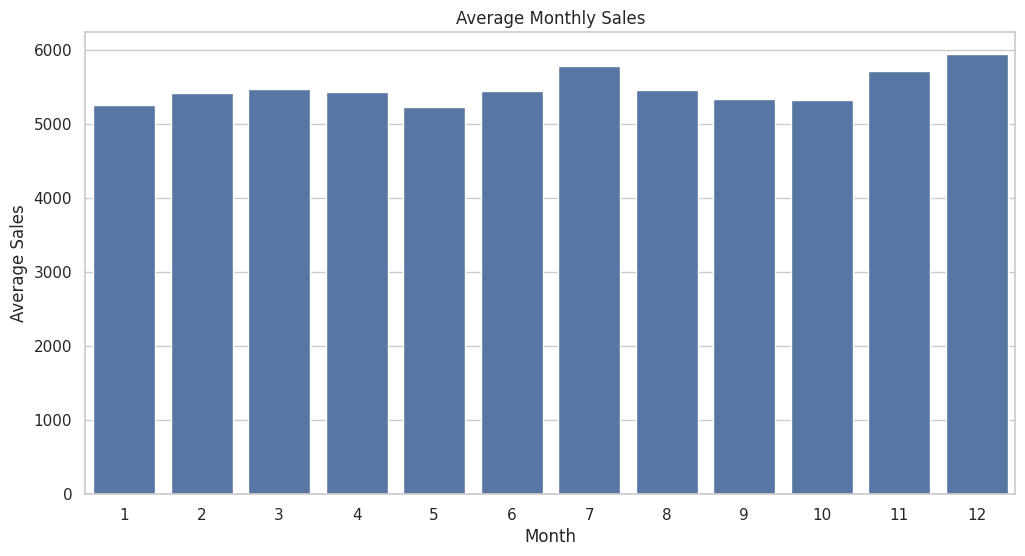

In [ ]:
# Seasonal purchase behavior (e.g., Christmas, Easter)
train_store['Month'] = train_store['Date'].dt.month
seasonal_sales = train_store.groupby('Month')['Sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Sales', data=seasonal_sales)
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

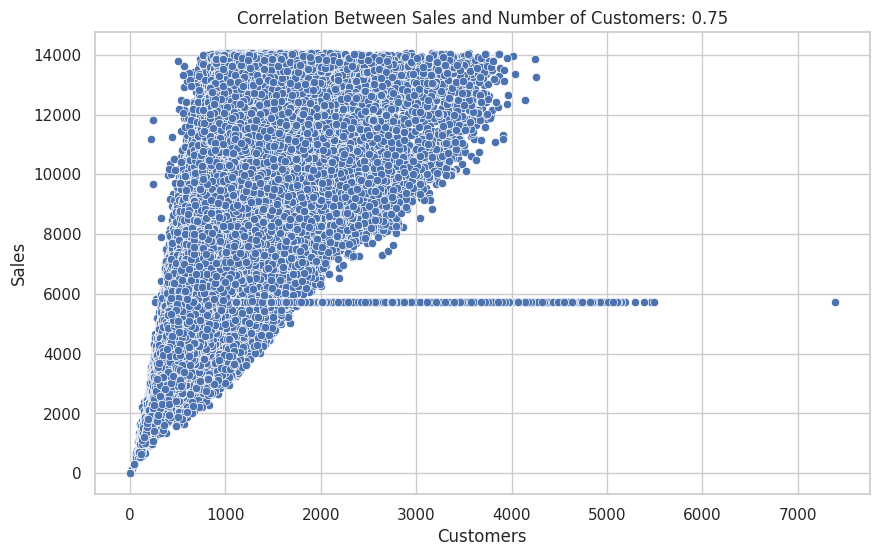

In [ ]:
# Function to analyze correlation between sales and number of customers
def analyze_sales_customer_correlation(data):
    logger.info("Analyzing correlation between sales and number of customers...")
    try:
        correlation = data[['Sales', 'Customers']].corr().iloc[0, 1]
        logger.info(f"Correlation between Sales and Number of Customers: {correlation:.2f}")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Customers', y='Sales', data=data)
        plt.title(f'Correlation Between Sales and Number of Customers: {correlation:.2f}')
        plt.xlabel('Customers')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted correlation between sales and number of customers.")
    except Exception as e:
        logger.error(f"Error plotting correlation between sales and number of customers: {e}")

# Apply analysis function
try:
    analyze_sales_customer_correlation(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

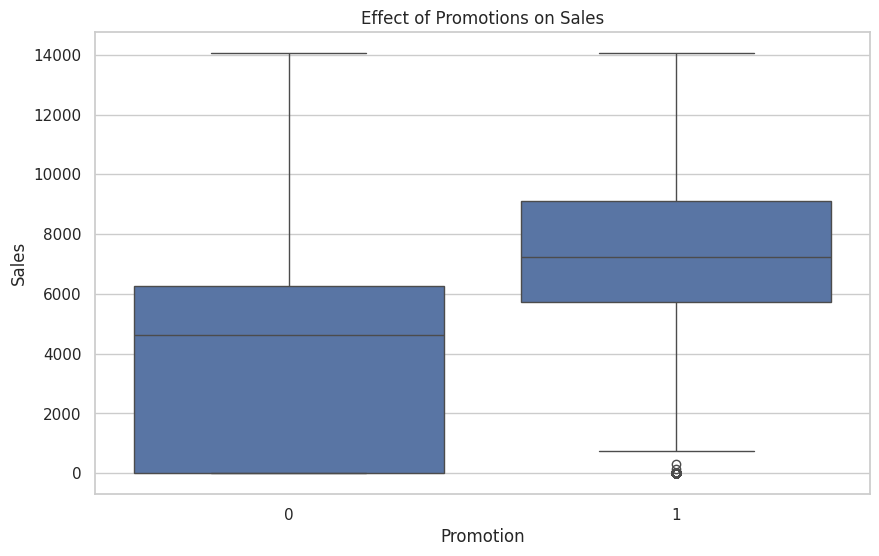

In [ ]:
# Function to analyze the effect of promotions on sales
def analyze_promo_effects(data):
    logger.info("Analyzing the effect of promotions on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Promo', y='Sales', data=data)
        plt.title('Effect of Promotions on Sales')
        plt.xlabel('Promotion')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted the effect of promotions on sales.")
    except Exception as e:
        logger.error(f"Error plotting the effect of promotions on sales: {e}")

# Apply analysis function
try:
    analyze_promo_effects(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

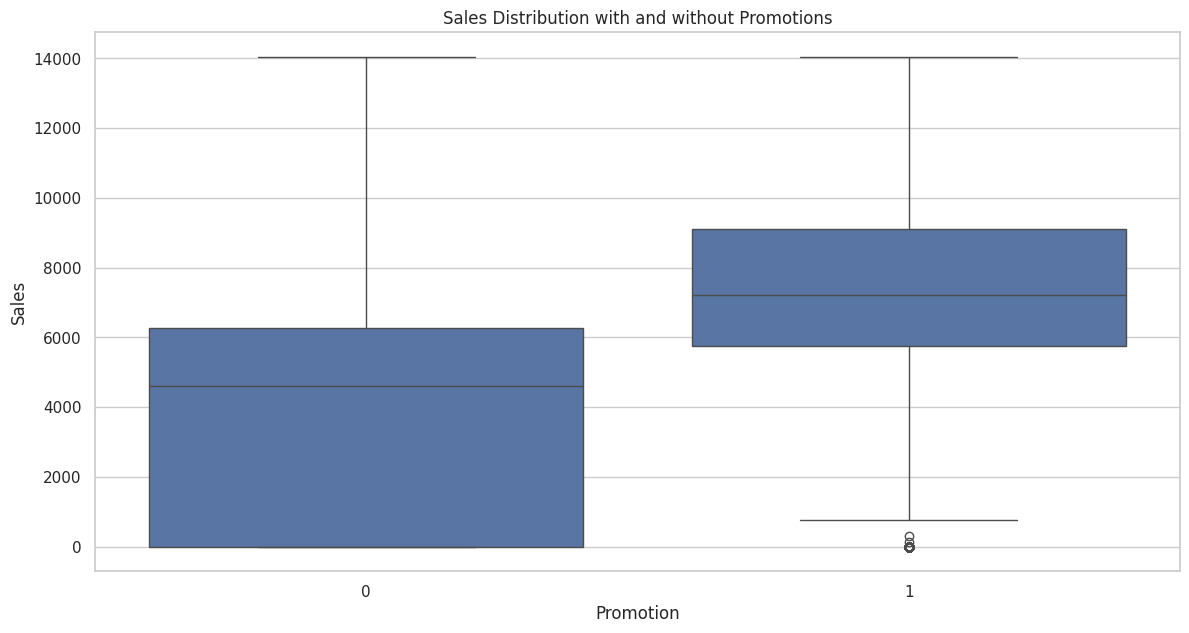

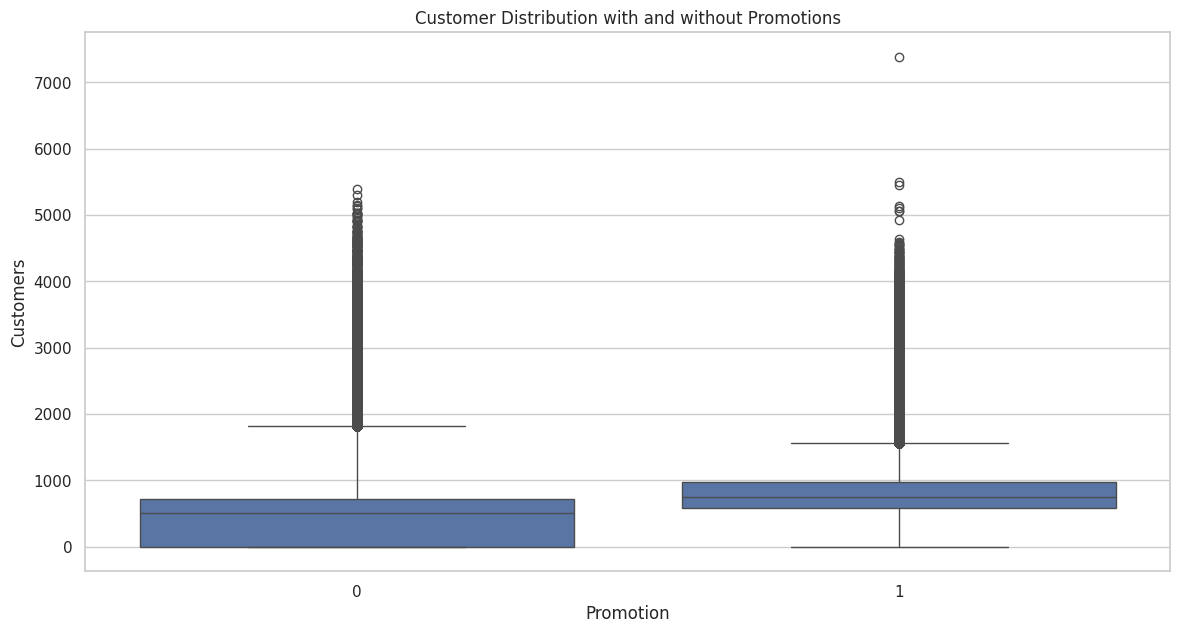

In [ ]:
# Could the Promos be Deployed in More Effective Ways? Which Stores Should Promos be Deployed In?
def analyze_promo_effectiveness(data):
    promo_data = data[data['Promo'] == 1]
    non_promo_data = data[data['Promo'] == 0]

    # Compare sales during and outside of promotions
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Promo', y='Sales', data=data)
    plt.title('Sales Distribution with and without Promotions')
    plt.xlabel('Promotion')
    plt.ylabel('Sales')
    plt.show()

    # Analyze effect on customer count
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Promo', y='Customers', data=data)
    plt.title('Customer Distribution with and without Promotions')
    plt.xlabel('Promotion')
    plt.ylabel('Customers')
    plt.show()

# Apply analysis function
try:
    analyze_promo_effectiveness(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

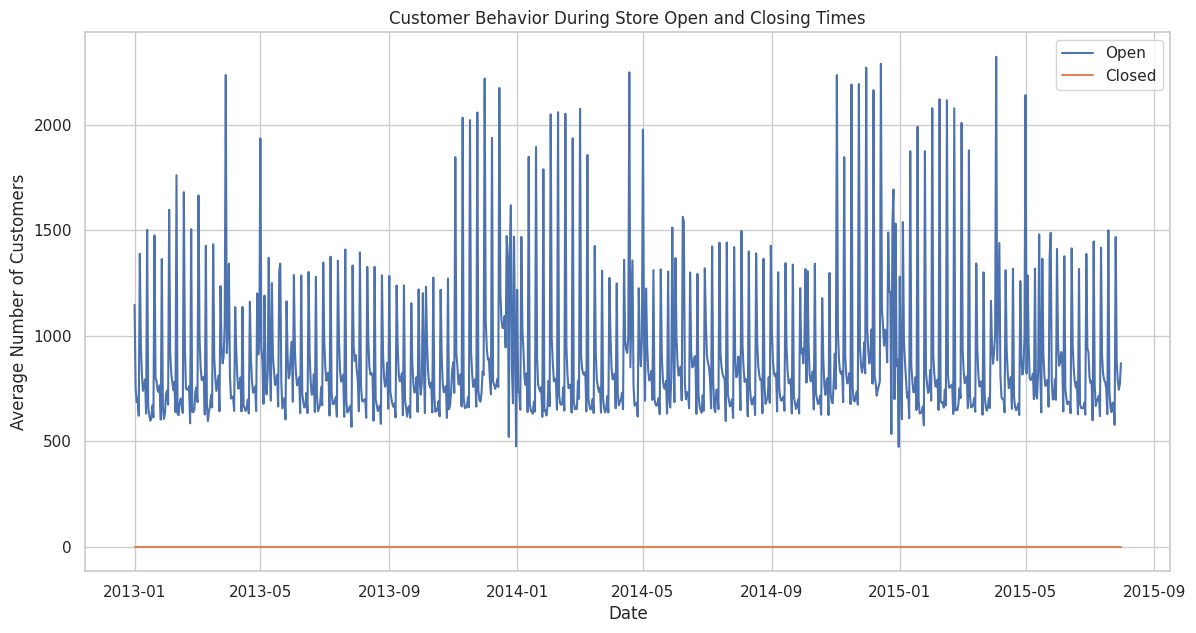

In [ ]:
# Function to analyze customer behavior during store open and closing times
def analyze_open_close_customer_behavior(data):
    logger.info("Analyzing customer behavior during store open and closing times...")
    try:
        open_stores = data[data['Open'] == 1]
        closed_stores = data[data['Open'] == 0]

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=open_stores.groupby('Date')['Customers'].mean(), label='Open')
        sns.lineplot(data=closed_stores.groupby('Date')['Customers'].mean(), label='Closed')
        plt.title('Customer Behavior During Store Open and Closing Times')
        plt.xlabel('Date')
        plt.ylabel('Average Number of Customers')
        plt.legend()
        plt.show()
        logger.info("Plotted customer behavior during store open and closing times.")
    except Exception as e:
        logger.error(f"Error plotting customer behavior during store open and closing times: {e}")

# Apply analysis function
try:
    analyze_open_close_customer_behavior(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

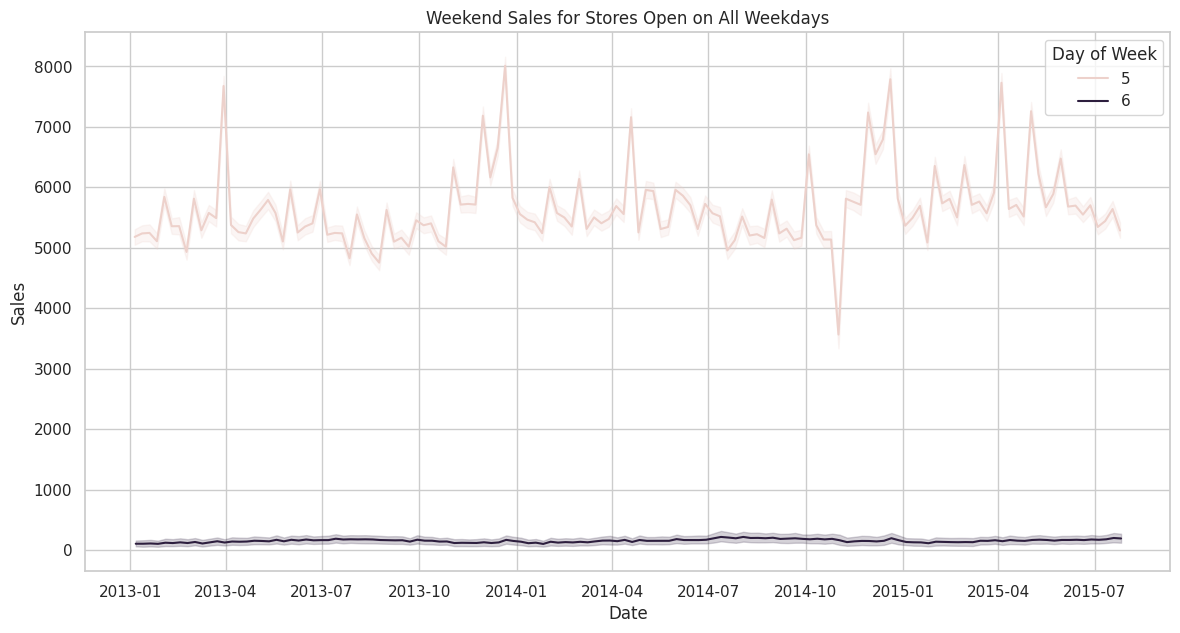

In [ ]:
# Which Stores are Opened on All Weekdays? How Does That Affect Their Sales on Weekends?

# Function to analyze store opening patterns
def analyze_weekday_opening(data):
    weekday_open = data[data['DayOfWeek'] < 5].groupby('Store')['Open'].sum()
    all_week_open_stores = weekday_open[weekday_open >= 5].index

    weekend_sales = data[(data['Store'].isin(all_week_open_stores)) & (data['DayOfWeek'] >= 5)]

    plt.figure(figsize=(14, 7))
    sns.lineplot(x='Date', y='Sales', hue='DayOfWeek', data=weekend_sales)
    plt.title('Weekend Sales for Stores Open on All Weekdays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Day of Week')
    plt.show()

# Apply analysis function
try:
    analyze_weekday_opening(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

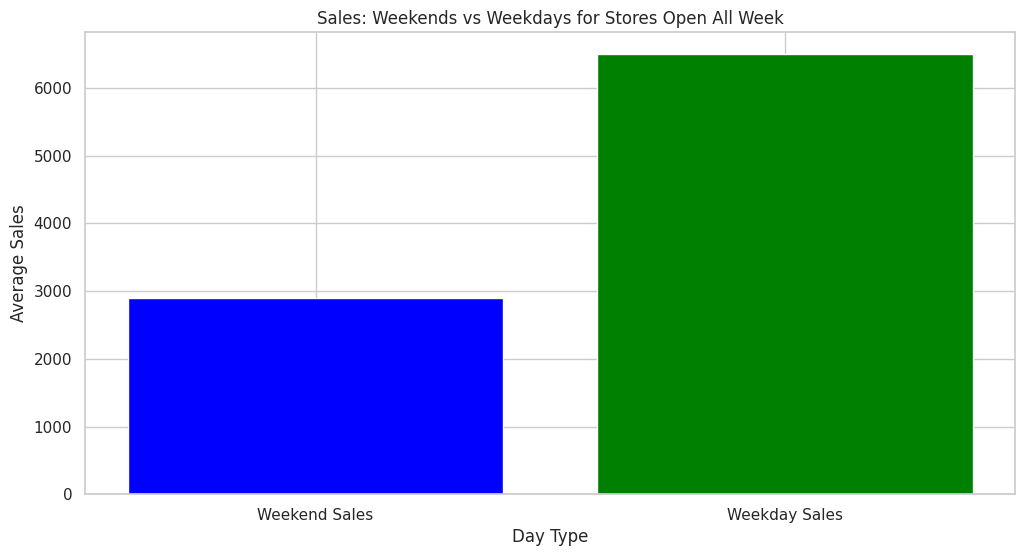

In [ ]:
# Stores opened on all weekdays
open_weekdays = train_store.groupby('Store')['DayOfWeek'].nunique()
stores_open_all_week = open_weekdays[open_weekdays == 7].index

weekend_sales = train_store[(train_store['Store'].isin(stores_open_all_week)) &
                            (train_store['DayOfWeek'].isin([5, 6]))]['Sales'].mean()

non_weekend_sales = train_store[(train_store['Store'].isin(stores_open_all_week)) &
                                (train_store['DayOfWeek'].isin([0, 1, 2, 3, 4]))]['Sales'].mean()

plt.figure(figsize=(12, 6))
plt.bar(['Weekend Sales', 'Weekday Sales'], [weekend_sales, non_weekend_sales], color=['blue', 'green'])
plt.title('Sales: Weekends vs Weekdays for Stores Open All Week')
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.show()

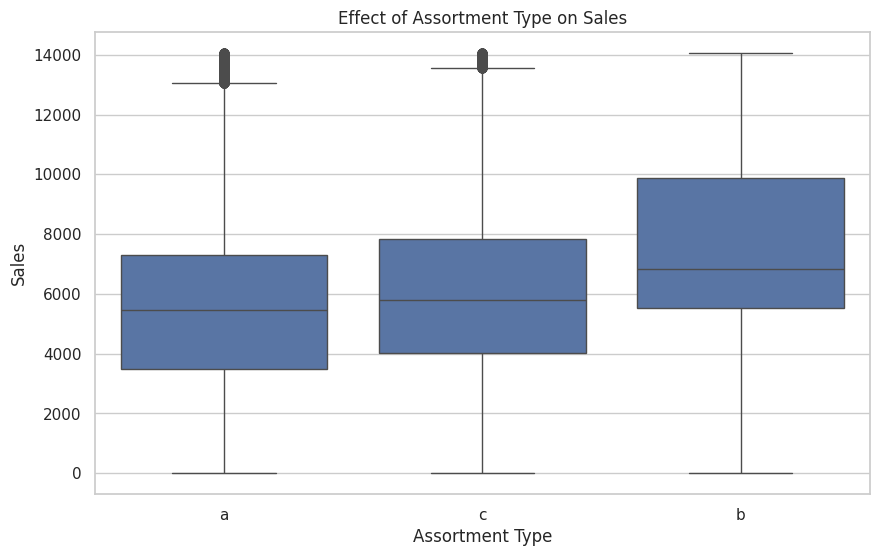

In [ ]:
# Function to analyze the effect of assortment type on sales
def analyze_assortment_effect(data):
    logger.info("Analyzing the effect of assortment type on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Assortment', y='Sales', data=data)
        plt.title('Effect of Assortment Type on Sales')
        plt.xlabel('Assortment Type')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted effect of assortment type on sales.")
    except Exception as e:
        logger.error(f"Error plotting effect of assortment type on sales: {e}")

# Apply analysis function
try:
    analyze_assortment_effect(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

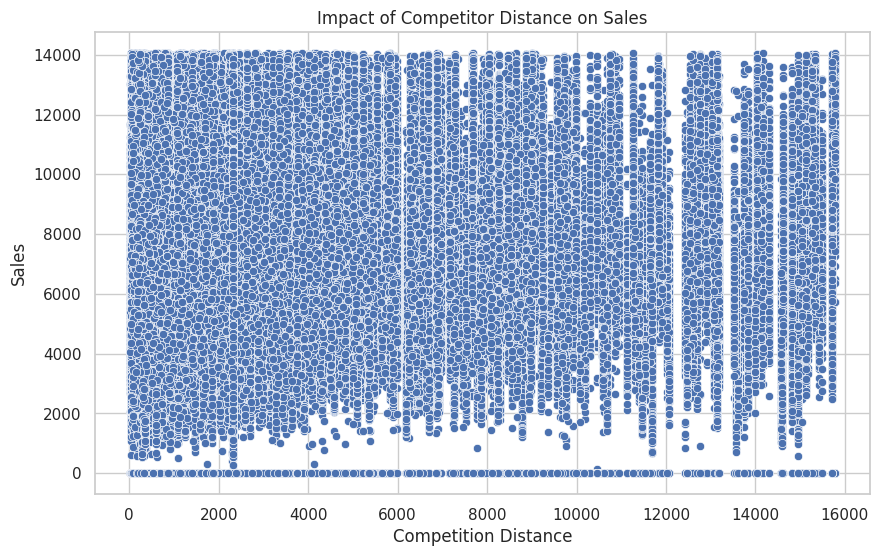

In [ ]:
# Function to analyze the impact of competitor distance on sales
def analyze_competitor_distance_effect(data):
    logger.info("Analyzing the impact of competitor distance on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='CompetitionDistance', y='Sales', data=data)
        plt.title('Impact of Competitor Distance on Sales')
        plt.xlabel('Competition Distance')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted impact of competitor distance on sales.")
    except Exception as e:
        logger.error(f"Error plotting impact of competitor distance on sales: {e}")

# Apply analysis function
try:
    analyze_competitor_distance_effect(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

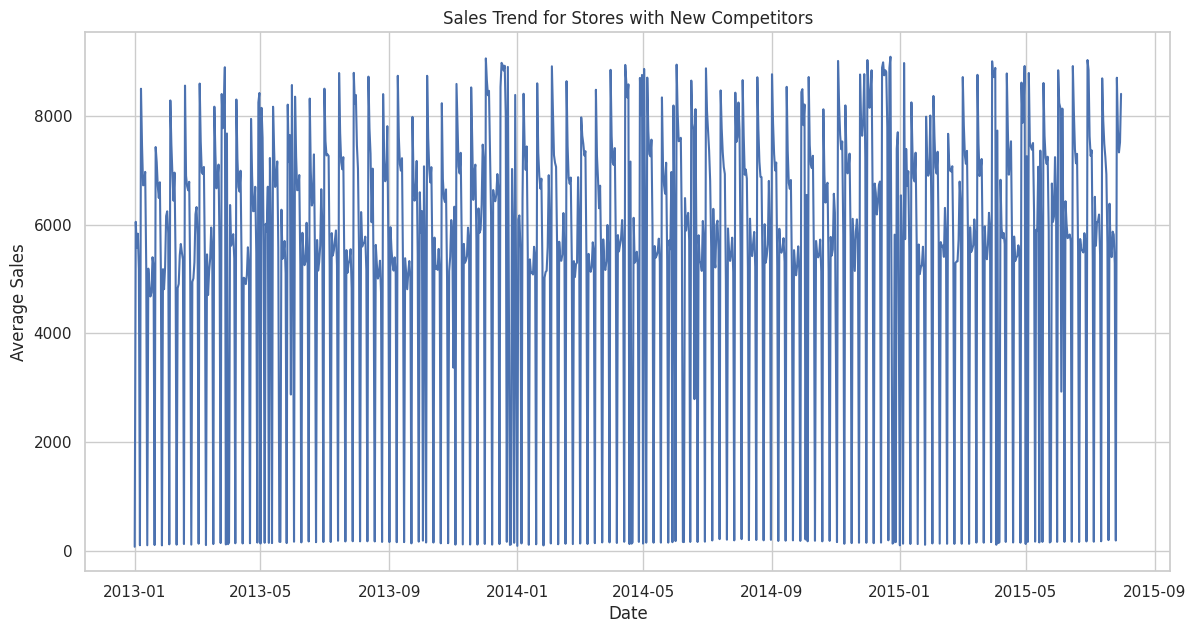

In [ ]:
# Function to analyze sales trend for stores with new competitors
def analyze_new_competitor_sales_trend(data):
    logger.info("Analyzing sales trend for stores with new competitors...")
    try:
        new_competitors = data[data['CompetitionOpenSinceDate'].notnull()]

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=new_competitors.groupby('Date')['Sales'].mean())
        plt.title('Sales Trend for Stores with New Competitors')
        plt.xlabel('Date')
        plt.ylabel('Average Sales')
        plt.show()
        logger.info("Plotted sales trend for stores with new competitors.")
    except Exception as e:
        logger.error(f"Error plotting sales trend for stores with new competitors: {e}")

# Apply analysis function
try:
    analyze_new_competitor_sales_trend(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

In [ ]:
train_store.to_csv('train_store.csv',index=False)
test_store.to_csv('test_store.csv',index=False)
files.download('train_store.csv')
files.download('test_store.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>